# IMDB Reviews(Sentiment Classification)

In [47]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [48]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete0RJE8I/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete0RJE8I/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete0RJE8I/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [49]:
import numpy as np
train_data, test_data = imdb['test'],imdb['test']

training_sentences = []
training_labels =[]
testing_sentences = []
testing_labels = []

for sent,label in train_data:
  training_sentences.append(sent.numpy().decode('utf8'))
  training_labels.append(label.numpy())
  
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [13]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
#training sentences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)
#testing sentences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [17]:
reverse_word_index = dict([(value,key) for (key, value) in word_index.items()])

def decode_review(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])
print(sequences[3])

poor shirley <OOV> tries hard to lend some <OOV> to this <OOV> gag inducing feel good movie but she's <OOV> by the run away sentimentality of a film that's not the least bit grounded in reality br br this was directed by curtis <OOV> did he have a <OOV> since we last heard from him <OOV> can do effective drama sprinkled with comedy as <OOV> by wonder boys so i don't know what happened to him here this is the kind of movie that doesn't want to accept that life is messy and <OOV> and that neat <OOV> endings however implausible they might be might make for a nice closing shot but come across as utterly phony if the people
Poor Shirley MacLaine tries hard to lend some gravitas to this mawkish, gag-inducing "feel-good" movie, but she's trampled by the run-away sentimentality of a film that's not the least bit grounded in reality.<br /><br />This was directed by Curtis Hanson? Did he have a lobotomy since we last heard from him? Hanson can do effective drama sprinkled with comedy, as evidenc

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 11526     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [21]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs,validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 10s 9ms/step - loss: 0.6104 - accuracy: 0.6289 - val_loss: 0.2914 - val_accuracy: 0.8792
Epoch 2/10
782/782 [==============================] - 7s 8ms/step - loss: 0.2316 - accuracy: 0.9123 - val_loss: 0.2625 - val_accuracy: 0.8916
Epoch 3/10
782/782 [==============================] - 7s 8ms/step - loss: 0.0909 - accuracy: 0.9784 - val_loss: 0.2924 - val_accuracy: 0.8895
Epoch 4/10
782/782 [==============================] - 7s 8ms/step - loss: 0.0227 - accuracy: 0.9984 - val_loss: 0.3359 - val_accuracy: 0.8899
Epoch 5/10
782/782 [==============================] - 7s 8ms/step - loss: 0.0059 - accuracy: 0.9998 - val_loss: 0.3768 - val_accuracy: 0.8887
Epoch 6/10
782/782 [==============================] - 7s 8ms/step - loss: 0.0023 - accuracy: 0.9999 - val_loss: 0.4055 - val_accuracy: 0.8907
Epoch 7/10
782/782 [==============================] - 7s 8ms/step - loss: 9.2930e-04 - accuracy: 1.0000 - val_loss: 0.4331 - val_accuracy: 0.8905
E

In [23]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [24]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [25]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences([sentence])
print(sequence)

NameError: ignored

# Sarcasm

In [2]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2021-04-01 17:06:09--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.1s    

2021-04-01 17:06:09 (46.4 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [7]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [8]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [30]:
vocab_size = 1000
embedding_dim = 64
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [31]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [32]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 16, 64)            64000     
_________________________________________________________________
global_average_pooling1d_4 ( (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 65,585
Trainable params: 65,585
Non-trainable params: 0
_________________________________________________________________


In [34]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.4976 - accuracy: 0.7581 - val_loss: 0.4011 - val_accuracy: 0.8141
Epoch 2/30
625/625 - 2s - loss: 0.3741 - accuracy: 0.8311 - val_loss: 0.4016 - val_accuracy: 0.8071
Epoch 3/30
625/625 - 2s - loss: 0.3629 - accuracy: 0.8345 - val_loss: 0.4000 - val_accuracy: 0.8134
Epoch 4/30
625/625 - 2s - loss: 0.3574 - accuracy: 0.8361 - val_loss: 0.3987 - val_accuracy: 0.8147
Epoch 5/30
625/625 - 2s - loss: 0.3526 - accuracy: 0.8393 - val_loss: 0.3984 - val_accuracy: 0.8171
Epoch 6/30
625/625 - 2s - loss: 0.3466 - accuracy: 0.8413 - val_loss: 0.3945 - val_accuracy: 0.8179
Epoch 7/30
625/625 - 2s - loss: 0.3399 - accuracy: 0.8464 - val_loss: 0.3972 - val_accuracy: 0.8189
Epoch 8/30
625/625 - 2s - loss: 0.3348 - accuracy: 0.8494 - val_loss: 0.3928 - val_accuracy: 0.8189
Epoch 9/30
625/625 - 2s - loss: 0.3308 - accuracy: 0.8504 - val_loss: 0.3937 - val_accuracy: 0.8219
Epoch 10/30
625/625 - 2s - loss: 0.3266 - accuracy: 0.8558 - val_loss: 0.3953 - val_accuracy: 0.8185

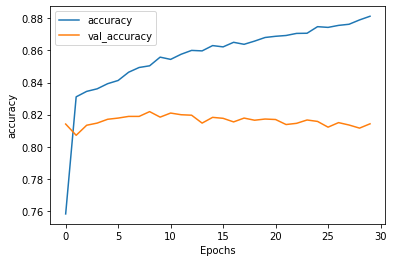

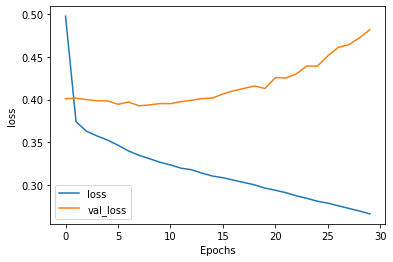

In [35]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [27]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store <OOV> <OOV> over secret <OOV> <OOV> for <OOV> <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [28]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 32)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [29]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.39985815]
 [0.6751342 ]]


#Subwords in imdb reviews

In [36]:
import tensorflow as tf
print(tf.__version__)


2.4.1


In [37]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteL82F88/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteL82F88/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteL82F88/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [38]:
train_data, test_data = imdb['train'], imdb['test']

In [39]:
tokenizer = info.features['text'].encoder

In [40]:
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [41]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [42]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


In [43]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [44]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d_5 ( (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 390       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [45]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 14s 32ms/step - loss: 0.6878 - accuracy: 0.5553 - val_loss: 0.6205 - val_accuracy: 0.7438
Epoch 2/10
391/391 [==============================] - 13s 31ms/step - loss: 0.5561 - accuracy: 0.7836 - val_loss: 0.4269 - val_accuracy: 0.8391
Epoch 3/10
391/391 [==============================] - 13s 32ms/step - loss: 0.3773 - accuracy: 0.8664 - val_loss: 0.3513 - val_accuracy: 0.8688
Epoch 4/10
391/391 [==============================] - 13s 32ms/step - loss: 0.2988 - accuracy: 0.8953 - val_loss: 0.3293 - val_accuracy: 0.8674
Epoch 5/10
391/391 [==============================] - 13s 31ms/step - loss: 0.2600 - accuracy: 0.9064 - val_loss: 0.3106 - val_accuracy: 0.8797
Epoch 6/10
391/391 [==============================] - 13s 31ms/step - loss: 0.2302 - accuracy: 0.9209 - val_loss: 0.3117 - val_accuracy: 0.8791
Epoch 7/10
391/391 [==============================] - 13s 31ms/step - loss: 0.2033 - accuracy: 0.9282 - val_loss: 0.3053 - val_accuracy:

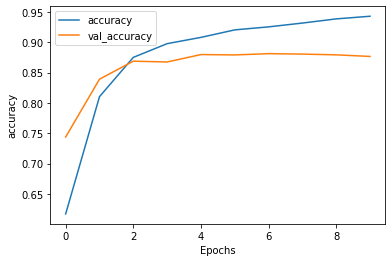

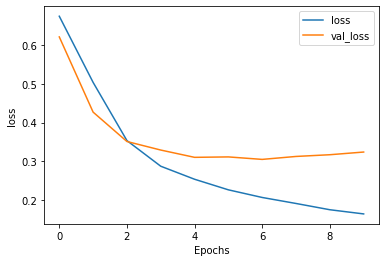

In [46]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')